In [1]:
import dataset
from tensorflow import estimator as tf_estimator
import models.losses as losses
import tensorflow as tf
from models.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from seggradcam.seggradcam import SegGradCAM, ClassRoI, PixelRoI
from seggradcam.seggradcam_block import SegGradCAM as SegGradCAM_block
from seggradcam.seggradcam_block import ClassRoI as ClassRoI_block
from seggradcam.seggradcam_block import PixelRoI as PixelRoI_block
from seggradcam.visualize_sgc import SegGradCAMplot
from matplotlib import colors
import matplotlib.pyplot as plt

ImportError: cannot import name 'estimator' from 'tensorflow' (c:\Users\Arye\miniconda3\envs\xai-fire\lib\site-packages\tensorflow\__init__.py)

# Preprocessing

In [2]:
def plot_dataset(n_rows, n_features,TITLES, inputs, labels, predictions, single=False):
  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
  fig = plt.figure(figsize=(15,6.5))
  if single == False:
    for i in range(n_rows):
      for j in range(n_features + 2):
        plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
        if i == 0:
          plt.title(TITLES[j], fontsize=13)
        if j < n_features - 1:
          plt.imshow(inputs[i, :, :, j], cmap='viridis')
        if j == n_features - 1:
          plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
        if j == n_features:
          plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j == n_features + 1:
          plt.imshow(predictions[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')
    plt.tight_layout()
  else:
    for j in range(n_features + 2):
      plt.subplot(1, n_features + 2, j + 1)
      plt.title(TITLES[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[n_rows, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[n_rows, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[n_rows, :, :, 0], cmap=CMAP, norm=NORM)
      if j == n_features + 1:
        plt.imshow(predictions[n_rows, :, :, 0], cmap=CMAP, norm=NORM)
      plt.axis('off')
    plt.tight_layout()

In [3]:
predict_threshold = 0.5

hparams = {
    # 数据路径
    'train_path': '../dataset/next_day_wildfire_spread_train*',
    'eval_path': '../dataset/next_day_wildfire_spread_eval*',
    'test_path': '../dataset/next_day_wildfire_spread_test*',
    
    # 特征
    'input_features': ['elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn',
                  'tmmx', 'vs', 'erc', 'population', 'PrevFireMask'],
    'output_features': ['FireMask'],
    
    # 方位通道
    'azimuth_in_channel': None,
    'azimuth_out_channel': None,
    
    # 数据和模型参数
    'data_sample_size': 64,
    'sample_size': 32,
    'output_sample_size': 32,
    'batch_size': 128,
    'shuffle': False,
    'shuffle_buffer_size': 10000,
    'compression_type': None,
    'input_sequence_length': 1,
    'output_sequence_length': 1,
    'repeat': False,
    'clip_and_normalize': True,
    'clip_and_rescale': False,
    
    # 数据增强
    'random_flip': False,
    'random_rotate': False,
    'random_crop': False,
    'center_crop': True,
    
    # 其他参数
    'downsample_threshold': 0.0,
    'binarize_output': True
}

TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask',
  'Predict\nmask',
]
# Number of rows of data samples to plot
n_rows = 30
# Number of data variables
n_features = 12
# Variables for controllong the color map for the fire masks

test_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.PREDICT
)



# Load Model

In [4]:
model_option = {"autoencoder": 'saved_model/autoencoder_model',
                 "unet": 'saved_model/unet_model', 
                 "resnet": 'saved_model/resnet_model', 
                 "vit": 'saved_model/vit_model'}

In [5]:
autoencoder = tf.keras.models.load_model('saved_model/autoencoder_model', custom_objects={
    'masked_weighted_cross_entropy_with_logits': losses.weighted_cross_entropy_with_logits_with_masked_class(pos_weight=3),
    'AUCWithMaskedClass': AUCWithMaskedClass(with_logits=True)
})
unet = tf.keras.models.load_model('saved_model/unet_model', custom_objects={
    'masked_weighted_cross_entropy_with_logits': losses.weighted_cross_entropy_with_logits_with_masked_class(pos_weight=3),
    'AUCWithMaskedClass': AUCWithMaskedClass(with_logits=True)
})
resnet = tf.keras.models.load_model('saved_model/resnet_model', custom_objects={
    'masked_weighted_cross_entropy_with_logits': losses.weighted_cross_entropy_with_logits_with_masked_class(pos_weight=3),
    'AUCWithMaskedClass': AUCWithMaskedClass(with_logits=True)
})
vit = tf.keras.models.load_model('saved_model/vit_model', custom_objects={
    'masked_weighted_cross_entropy_with_logits': losses.weighted_cross_entropy_with_logits_with_masked_class(pos_weight=3),
    'AUCWithMaskedClass': AUCWithMaskedClass(with_logits=True)
})

In [6]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1728        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 16)   192         ['input_1[0][0]']            

In [7]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 separable_conv2d (SeparableCon  (None, 32, 32, 16)  316         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['separable_conv2d[0][0]']       
 alization)                                                                                   

In [8]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1744        ['input_1[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 1, 1, 2048)   23628480    ['conv2d[0][0]']                 
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 2, 2, 2048)   0           ['resnet50[0][0]']           

In [9]:
vit.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1744        ['input_1[0][0]']                
                                                                                                  
 patch_extract (patch_extract)  (None, 256, 64)      0           ['conv2d[0][0]']                 
                                                                                                  
 patch_embedding (patch_embeddi  (None, 256, 128)    41088       ['patch_extract[0][0]']      

In [10]:
from keras_flops import get_flops
ae_flops = get_flops(autoencoder, batch_size=1)
ae_gflops = ae_flops / 1e9
print(f"Total GFLOPs for AutoEncoder: {ae_gflops}")

unet_flops = get_flops(unet, batch_size=1)
unet_gflops = unet_flops / 1e9
print(f"Total GFLOPs for Unet: {unet_gflops}")

resnet_flops = get_flops(resnet, batch_size=1)
resnet_gflops = resnet_flops / 1e9
print(f"Total GFLOPs for ResNet: {resnet_gflops}")

vit_flops = get_flops(vit, batch_size=1)
vit_gflops = vit_flops / 1e9
print(f"Total GFLOPs for ViT: {vit_gflops}")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Total GFLOPs for AutoEncoder: 0.037857284
Total GFLOPs for Unet: 0.024032206
Total GFLOPs for ResNet: 0.451858058
Total GFLOPs for ViT: 1.146231344


53/53 [==============================] - 3s 32ms/step


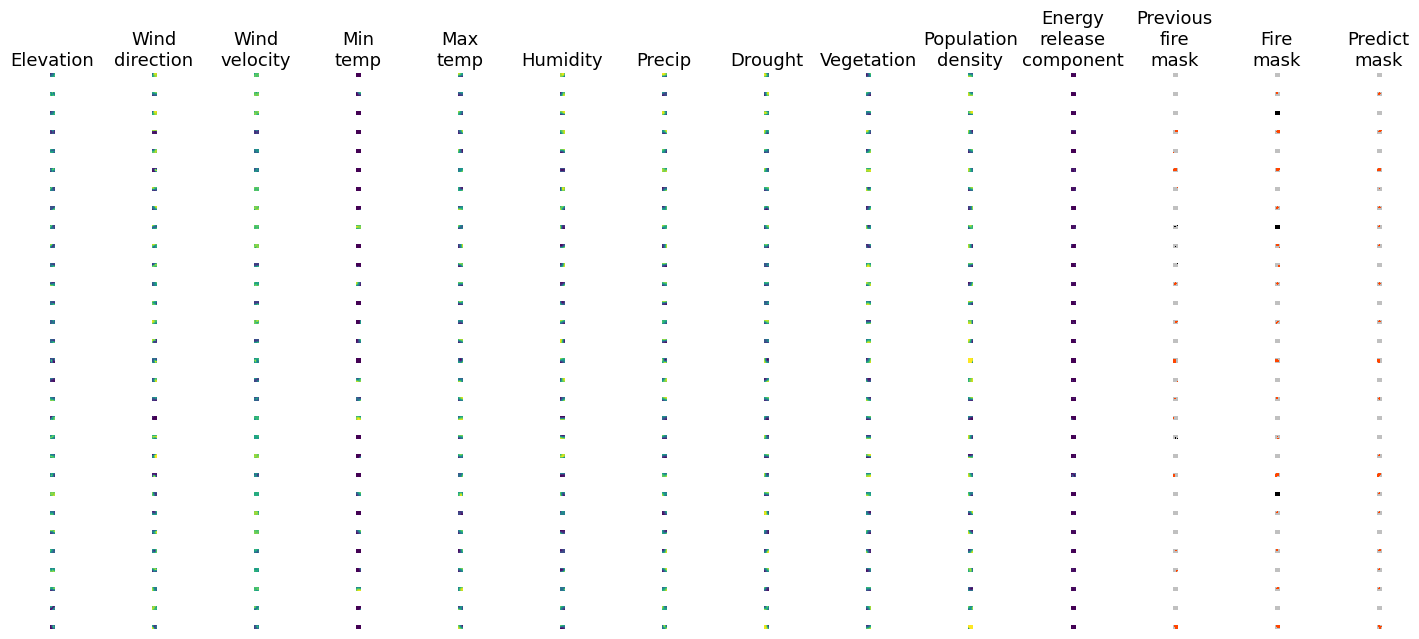

In [ ]:
features = []
labels = []
for feature, label in test_dataset:
    features.append(feature.numpy())
    labels.append(label.numpy())
all_features = tf.concat(features, axis=0)
all_labels = tf.concat(labels, axis=0)

# autoencoder predictions
autoencoder_logits = autoencoder.predict(all_features)
autoencoder_y_pred = tf.math.sigmoid(autoencoder_logits)
# unet
unet_logits = unet.predict(all_features)
unet_y_pred = tf.math.sigmoid(unet_logits)
# resnet
resnet_logits = resnet.predict(all_features)
resnet_y_pred = tf.math.sigmoid(resnet_logits)
# vit
vit_logits = vit.predict(all_features)
vit_y_pred = tf.math.sigmoid(vit_logits)
#mask = tf.cast(tf.not_equal(all_labels, -1), tf.float32)
autoencoder_predictions = tf.cast(autoencoder_y_pred >= predict_threshold, 'int32')
unet_predictions = tf.cast(unet_y_pred >= predict_threshold, 'int32')
resnet_predictions = tf.cast(resnet_y_pred >= predict_threshold, 'int32')
vit_predictions = tf.cast(vit_y_pred >= predict_threshold, 'int32')


inputs, labels = next(iter(test_dataset))
plot_dataset(n_rows, n_features, TITLES, inputs, labels, unet_predictions)

# Seg-Grad-Cam

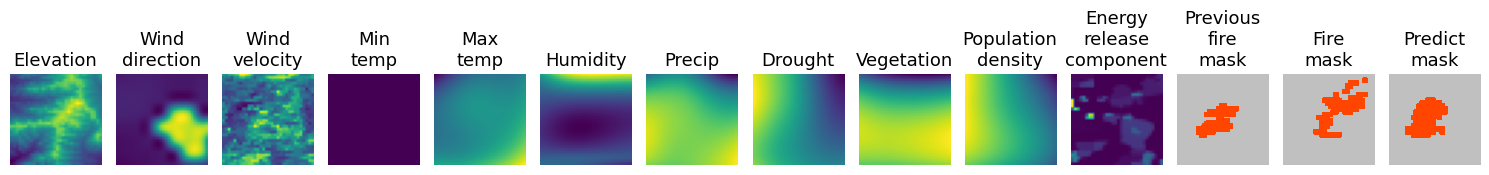

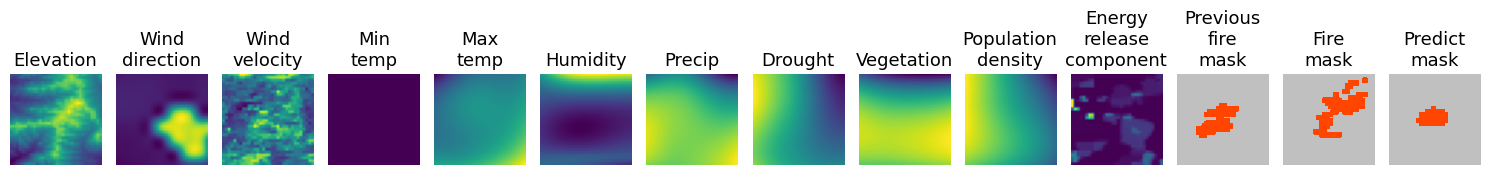

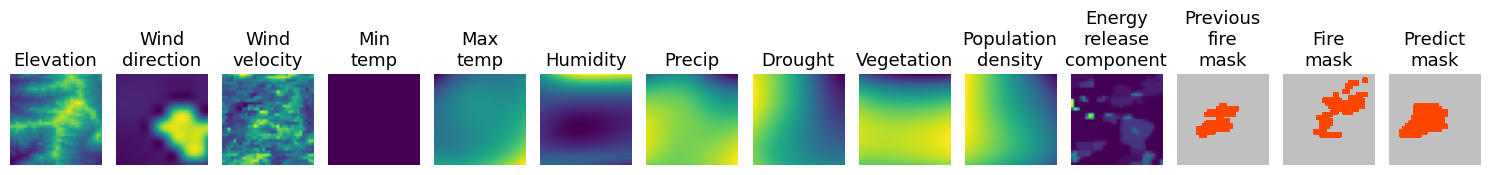

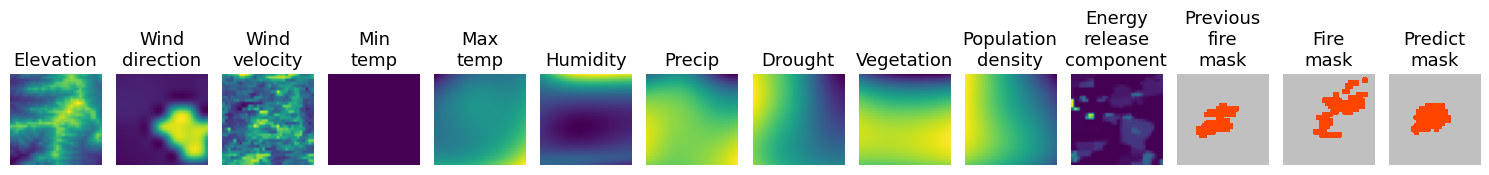

In [ ]:
cls = 1
image_id = 5
image =  inputs[image_id]
label = labels[image_id]

unet_prop_from_layer = unet.layers[-1].name
unet_prop_to_layer = unet.layers[1].name

autoencoder_prop_from_layer = autoencoder.layers[-1].name
autoencoder_prop_to_layer = autoencoder.layers[1].name

vit_prop_from_layer = vit.layers[-1].name
vit_prop_to_layer = vit.layers[1].name

resnet_prop_from_layer = resnet.layers[-1].name
resnet_prop_to_layer = resnet.layers[1].name

plot_dataset(image_id, n_features, TITLES, inputs, labels, autoencoder_predictions, single=True)
plot_dataset(image_id, n_features, TITLES, inputs, labels, resnet_predictions, single=True)
plot_dataset(image_id, n_features, TITLES, inputs, labels, unet_predictions, single=True)
plot_dataset(image_id, n_features, TITLES, inputs, labels, vit_predictions, single=True)

## B. Seg-Grad-CAM for a class

### Grad-Cam for Class 1(Fire)

1/1 [==============================] - 0s 209ms/step
Precision: 0.0646
Recall: 0.6413
Shape of RoI:  (32, 32)
Lengths of i and j index lists: 855 855
1/1 [==============================] - 0s 78ms/step
Precision: 0.0765
Recall: 0.8152
Shape of RoI:  (32, 32)
Lengths of i and j index lists: 906 906
1/1 [==============================] - 0s 16ms/step
Precision: 0.0757
Recall: 0.7500
Shape of RoI:  (32, 32)
Lengths of i and j index lists: 842 842
1/1 [==============================] - 0s 65ms/step
Precision: 0.0720
Recall: 0.7391
Shape of RoI:  (32, 32)
Lengths of i and j index lists: 876 876


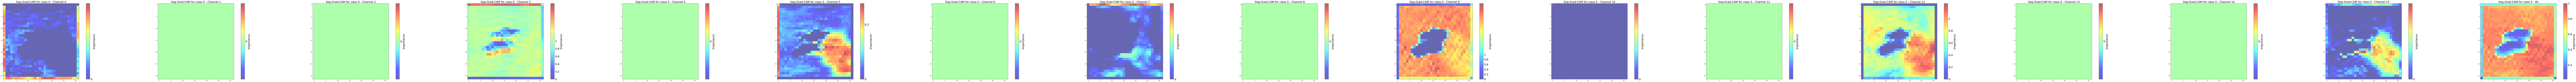

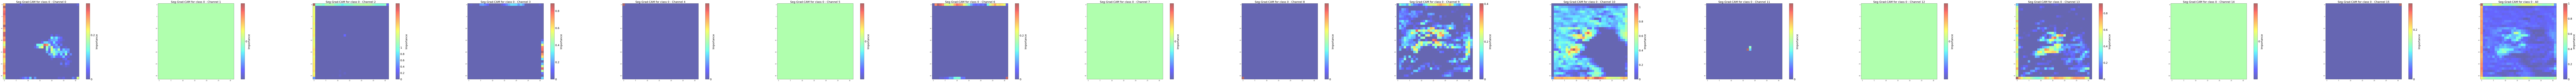

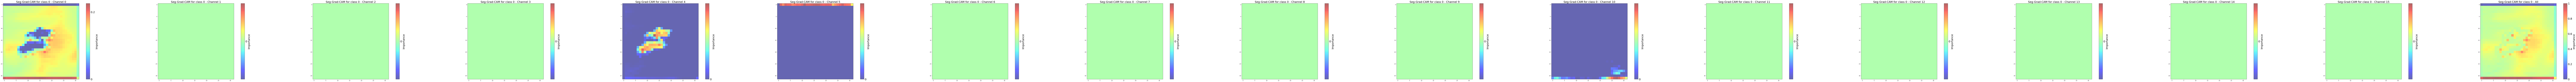

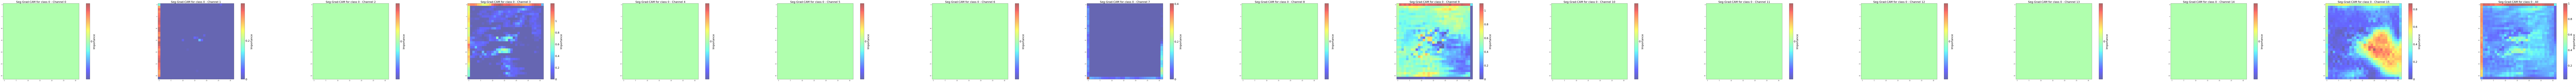

In [ ]:
cls = 0
posti_w = True
abs_w = False
tp = 0
fp = 1
normalize = True
# autoencoder
clsroi = ClassRoI(autoencoder,image,cls,label,tp,fp)
clssgc = SegGradCAM(autoencoder, image, cls,  autoencoder_prop_to_layer,autoencoder_prop_from_layer, roi=clsroi,
                 normalize=normalize, abs_w=abs_w, posit_w=posti_w)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, autoencoder, None, None)
clsplotter.explainClass()

# resnet
clsroi = ClassRoI(resnet,image,cls,label,tp,fp)
clssgc = SegGradCAM(resnet, image, cls,  resnet_prop_to_layer,resnet_prop_from_layer, roi=clsroi,
                 normalize=normalize, abs_w=abs_w, posit_w=posti_w)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, resnet, None, None)
clsplotter.explainClass()

# unet
clsroi = ClassRoI(unet,image,cls,label,tp,fp)
clssgc = SegGradCAM(unet, image, cls,  unet_prop_to_layer,unet_prop_from_layer, roi=clsroi,
                 normalize=normalize, abs_w=abs_w, posit_w=posti_w)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, unet, None, None)
clsplotter.explainClass()

# vit
clsroi = ClassRoI(vit,image,cls,label,tp,fp)
clssgc = SegGradCAM(vit, image, cls,  vit_prop_to_layer,vit_prop_from_layer, roi=clsroi,
                 normalize=normalize, abs_w=abs_w, posit_w=posti_w)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, vit, None, None)
clsplotter.explainClass()

### Grad-Cam for Class 0(no Fire)

In [ ]:
cls = 0

# autoencoder
clsroi = ClassRoI(autoencoder,image,cls)
clssgc = SegGradCAM(autoencoder, image, cls,  autoencoder_prop_to_layer,autoencoder_prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, autoencoder, None, None)
clsplotter.explainClass()

# resnet
clsroi = ClassRoI(resnet,image,cls)
clssgc = SegGradCAM(resnet, image, cls,  resnet_prop_to_layer,resnet_prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, resnet, None, None)
clsplotter.explainClass()

# unet
clsroi = ClassRoI(unet,image,cls)
clssgc = SegGradCAM(unet, image, cls,  unet_prop_to_layer,unet_prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, unet, None, None)
clsplotter.explainClass()

# vit
clsroi = ClassRoI(vit,image,cls)
clssgc = SegGradCAM(vit, image, cls,  vit_prop_to_layer,vit_prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, vit, None, None)
clsplotter.explainClass()

TypeError: __init__() missing 1 required positional argument: 'true_label'